SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #10: DL in TS Forecasting </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - deep learning in time series forecasing, time series classificaiton problem, dynamic timeseries warping algorithm, 

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# DL in Time Series Forecasting
**Question:**
* Does DL bring something completely new to time series forecasting?
* When DL can boost some accuracy in time series forecasting problem?
  

## LSTM vs ARMA 
LSTM: <img src = 'https://www.codeproject.com/KB/cross-platform/5165357/lstm-cell.png'>


<br></br>
ARMA:$~x_t = \underbrace{c+\sum_{i=1}^{\color{red}{p}} \alpha_ix_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}{q}} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$;

<br></br>
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Memory%20term%20in%20TSF.PNG?raw=true' width=600pt>

**Questions**:
* What are key differences between ARMA and LSTM approach?
 - Answer:
    - LSTM contains non-linear components
    - LSTM uses more complicated combinations of components

## DL advantages
**Questions**
* When non-linear transformations can be useful?
* How to increase genralization power of the ML model?

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/DL_Advantages.PNG?raw=true' width = 600pt>

<center>Enzo Busetti etc. Deep Learning for Time Series Modeling. CS 229 final Project Report, 2012.</center>





**Questions**
* What data can require additional complexity in models?

   - Energy Consumption Forecasting

Learning method    | RMSE               | %RMSE              
-------------------|------------------  | -----------------
Kernel Regression  |         1540       | $~~~~~$ 8.3%
Feed-Forward NN    |         1250       | $~~~~~$ 6.7%
Deep-Forward NN    |         1130       | $~~~~~$ 5.9%
Deep-Recurrent NN  |          530       | $~~~~~$ 2.8%


## Example of Forecasts

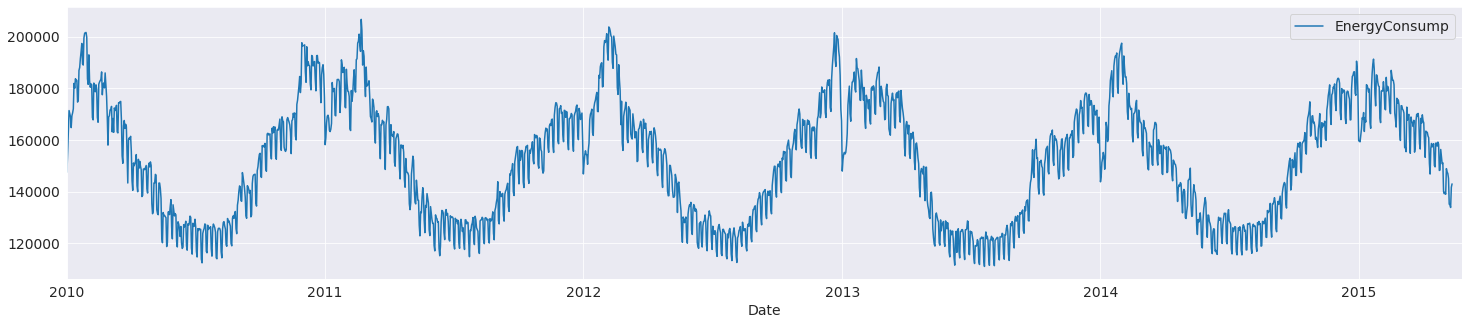

In [39]:
# Read data (time series)
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consump.csv', sep=',', decimal='.', parse_dates=True,
                  dayfirst=False, index_col='Date')
ts = ts.sort_index() # sort index
ts[['EnergyConsump']].plot()

In [10]:
myts2 = ts[['EnergyConsump', 'Temp1', 'Temp2']]
myts2 = myts2.dropna()
from sklearn.preprocessing import MinMaxScaler
myts2.values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(myts2.values)

In [48]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      # print(bundle)
        # define dates for each SKU and Store pairs        
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "{0}_lag{1}_wdw{2}_{3}_{4}".
                          format(target_var,l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            
    return out_df

In [49]:
ts["weekday"] = ts.reset_index().Date.dt.weekday
ts["monthday"] = ts.reset_index().Date.dt.day
ts['is_weekend'] = ts.weekday.isin([5,6])*1

In [50]:
# Generate ML features
flts = {'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}
# data with added lagged features
ts_lagged_features = lagged_features(ts, target_var = 'EnergyConsump'
                    , org_id_columns = ['ZSP']
                    , all_id_columns =['ZSP', 'Date']
                    , lags = [7, 365]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = flts
                    )

In [14]:
# split into train and test sets
values = ts_lagged_features[ts_lagged_features.columns[3:]].values
n_train_days = 365*4
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 1, 21) (1460,) (492, 1, 21) (492,)


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [16]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/50
21/21 [==============================] - 3s 35ms/step - loss: 0.2461 - val_loss: 0.1242
Epoch 2/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0910 - val_loss: 0.0569
Epoch 3/50
21/21 [==============================] - 0s 11ms/step - loss: 0.0596 - val_loss: 0.0540
Epoch 4/50
21/21 [==============================] - 0s 15ms/step - loss: 0.0544 - val_loss: 0.0512
Epoch 5/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0528 - val_loss: 0.0499
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0516 - val_loss: 0.0490
Epoch 7/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0505 - val_loss: 0.0476
Epoch 8/50
21/21 [==============================] - 0s 14ms/step - loss: 0.0492 - val_loss: 0.0465
Epoch 9/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0485 - val_loss: 0.0453
Epoch 10/50
21/21 [==============================] - 0s 11ms/step - loss: 0.0474 - val_loss: 0.0449
Epoch 11/

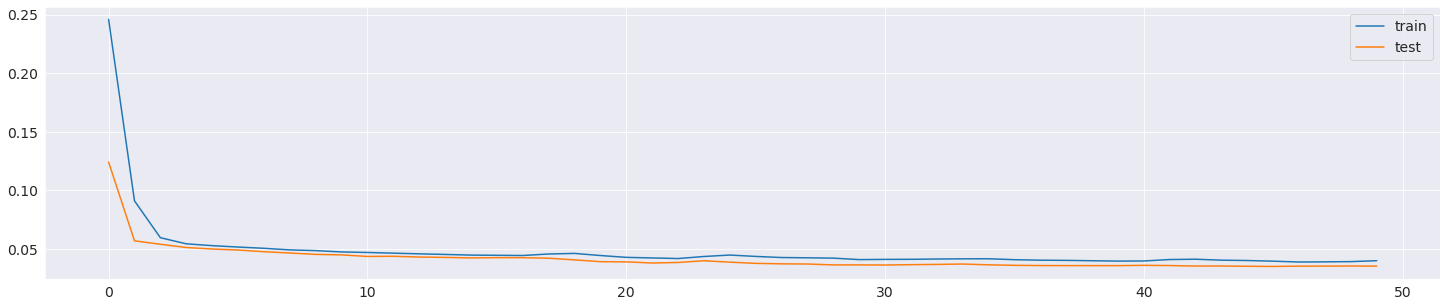

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, np.zeros((len(yhat), 2))), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_X.squeeze(), train_y)
# make a prediction
lr_yhat = lr.predict(test_X)[:, None]
# invert scaling for forecast
lr_inv_yhat = np.concatenate((lr_yhat, np.zeros((len(lr_yhat), 2))), axis=1)

lr_inv_yhat = scaler.inverse_transform(lr_inv_yhat)
lr_inv_yhat = lr_inv_yhat[:,0]

In [21]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, np.zeros((len(test_y), 2))), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Text(0.5, 1.0, 'RNN RMSE = 4523.458420592249, \r\n LR RMSE = 4327.691008883056')

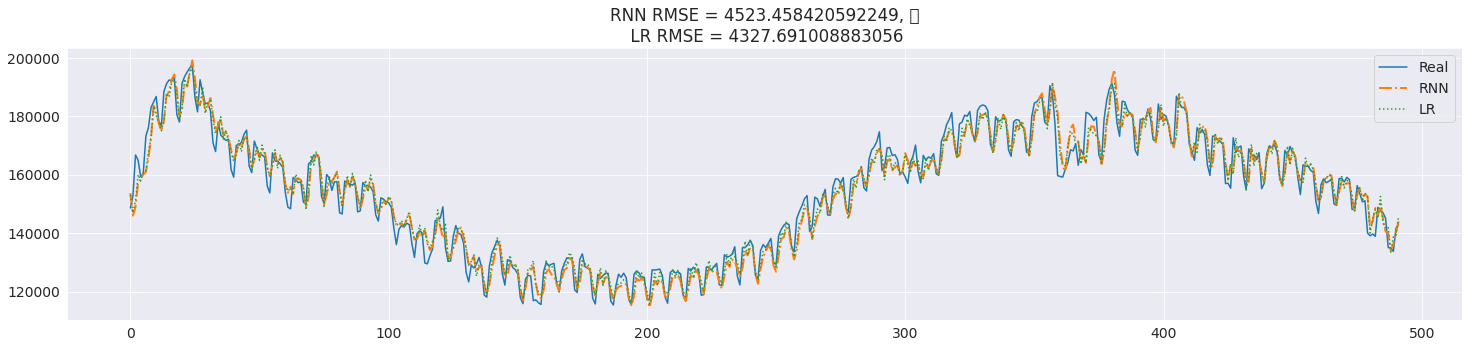

In [29]:
from sklearn.metrics import mean_squared_error

plt.figure()
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, '-.', linewidth=2, label='RNN')
plt.plot(lr_inv_yhat, ':', label='LR')
plt.legend()
plt.title('RNN RMSE = {0}, \r\n LR RMSE = {1}'.format(np.sqrt(mean_squared_error(inv_y, inv_yhat)), 
                                                                 np.sqrt(mean_squared_error(inv_y, lr_inv_yhat))))

# Time Series Classification
**Questions**
* What is a purpose of TS classification problem?
  - Feature generation
    - Seasonal or not Seasonal
    - Sparse (Intermittent) or not sparse (intermittent)
    - Driver(e.g. Weather)-dependent or not-driver dependent
  
  All can be done using some statistical analysis (STL-decomposition, Sparse-data-test, correcation analysis)

  - Detection of changes in time series
    - https://github.com/alan-turing-institute/sktime/blob/main/examples/02_classification_univariate.ipynb

  - Comparison of signals 
    - https://makeabilitylab.github.io/physcomp/signals/ComparingSignals/index.html


## Time series Warping
<img src = 'https://miro.medium.com/max/850/1*uFicSZjqkNBfsyrsJw7J9g.jpeg' height = 500pt >

# Conclusion
* Complicated approaches should be applied only for complicated ts
* Time Series classification algorithms originally based on dynamic time series warping algorithm 

<!-- **Materials**
* 
*  -->